<a href="https://colab.research.google.com/github/vanchanr/arXiv-analytics/blob/main/arXiv_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
keyword = input("Enter the keyword to search papers: ")

Enter the keyword to search papers: Blockchain


In [37]:
!pip3 install xmltodict
import xmltodict
import requests
import json
import time
import re
import matplotlib.pyplot as plt
from datetime import datetime

In [38]:
def cleanSpaces(s):
    s = s.replace('\n', ' ')
    s = re.sub(r'\s\s+', ' ', s)
    return s

def createPaper(paper):
    for field in ['author', 'category']:
        if type(paper[field]) is not list:
            paper[field] = [paper[field]]
    isCsPaper = False
    allCategories = []
    for category in paper['category']:
        allCategories.append(category['@term'])
        if category['@term'].startswith('cs.'):
            isCsPaper = True
    if isCsPaper:
        return {
            'title': cleanSpaces(paper['title']),
            'author': [author['name'] for author in paper['author']],
            'abstract': cleanSpaces(paper['summary']),
            'lastUpdated': paper['updated'],
            'category': allCategories,
            'url': paper['id']
        }
    else:
        return None

def plotHelper(plotBy, countData):
    plt.bar(countData.keys(), countData.values())
    for key in countData:
        plt.text(key, countData[key], str(countData[key]), va='bottom', ha='center')
    plt.title(f'Number of {keyword} Papers by {plotBy}')
    plt.xlabel(plotBy)
    plt.ylabel('Count')
    plt.xticks(rotation=30)
    plt.show()

def plotYearWise(jsonDump):
    yearCountData = {}
    for paper in jsonDump:
        lastUpdated = paper['lastUpdated']
        dt = datetime.strptime(lastUpdated, '%Y-%m-%dT%H:%M:%SZ')
        year = str(dt.year)
        if year in yearCountData:
            yearCountData[year] += 1
        else:
            yearCountData[year] = 1
    
    yearCountData = dict(sorted(yearCountData.items()))
    plotHelper('year', yearCountData)

#field: 'author', 'category'
#plot top 10
def plotFieldWise(jsonDump, field):
    if field in ['author', 'category']:
        data = {}
        for paper in jsonDump:
            for name in paper[field]:
                if name in data:
                    data[name] += 1
                else:
                    data[name] = 1
        data = dict(sorted(data.items(), key=lambda x: x[1], reverse=True)[:10])
        plotHelper(field, data)

In [39]:
url = 'http://export.arxiv.org/api/query'
queryParams = {
    'search_query': f'all:"{keyword}"',
    'start': 0,
    'max_results': 500
}

outLs = []
batch = 1
while batch <= 100:
    try:
        resp = requests.get(url, params=queryParams)
        resp = xmltodict.parse(resp.text)
        resp = resp['feed']
        if 'entry' in resp:
            curBatch = []
            for paper in resp['entry']:
                paper = createPaper(paper)
                if paper is not None:
                    curBatch.append(paper)
            outLs.extend(curBatch)
            print(f"Batch-{batch}: Added {len(curBatch)} CS papers")
        else:
            break
    except Exception as ex:
        print(f"Error while processing batch-{batch}: {ex}")
    batch += 1
    queryParams['start'] += 500
    time.sleep(0.5)
print(f"Total CS papers matching '{keyword}':", len(outLs))
try:
    with open(f'{keyword}.json', mode='w', encoding='utf-8') as jsonFile:
        json.dump(outLs, jsonFile, indent=2, ensure_ascii=False)
        print("Successfully created the json dump file !")
except Exception as ex:
    print(f"Error while creating json dump file: {ex}")


Batch-1: Added 494 CS papers
Batch-2: Added 494 CS papers
Batch-3: Added 485 CS papers
Batch-4: Added 388 CS papers
Total CS papers matching 'Blockchain': 1861
Successfully created the json dump file !


In [40]:
jsonDump = {}
with open(f'{keyword}.json', mode='r') as jsonFile:
    jsonDump = json.load(jsonFile)

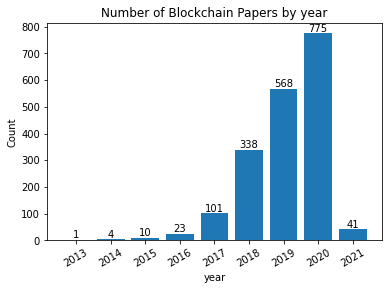

In [41]:
plotYearWise(jsonDump)

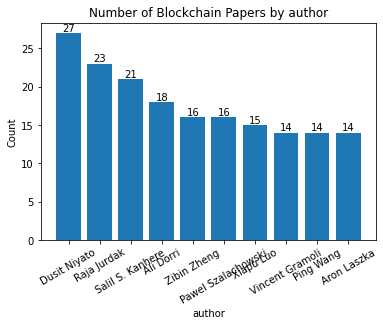

In [42]:
plotFieldWise(jsonDump, 'author')

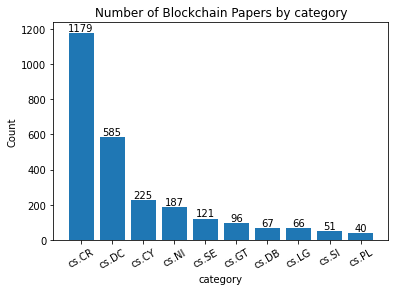

In [43]:
plotFieldWise(jsonDump, 'category')

In [44]:
nltk_stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
english_common_words = ['a', 'abandon', 'ability', 'able', 'abortion', 'about', 'above', 'abroad', 'absence', 'absolute', 'absolutely', 'absorb', 'abuse', 'academic', 'accept', 'access', 'accident', 'accompany', 'accomplish', 'according', 'account', 'accurate', 'accuse', 'achieve', 'achievement', 'acid', 'acknowledge', 'acquire', 'across', 'act', 'action', 'active', 'activist', 'activity', 'actor', 'actress', 'actual', 'actually', 'ad', 'adapt', 'add', 'addition', 'additional', 'address', 'adequate', 'adjust', 'adjustment', 'administration', 'administrator', 'admire', 'admission', 'admit', 'adolescent', 'adopt', 'adult', 'advance', 'advanced', 'advantage', 'adventure', 'advertising', 'advice', 'advise', 'adviser', 'advocate', 'affair', 'affect', 'afford', 'afraid', 'african', 'african-american', 'after', 'afternoon', 'again', 'against', 'age', 'agency', 'agenda', 'agent', 'aggressive', 'ago', 'agree', 'agreement', 'agricultural', 'ah', 'ahead', 'aid', 'aide', 'aids', 'aim', 'air', 'aircraft', 'airline', 'airport', 'album', 'alcohol', 'alive', 'all', 'alliance', 'allow', 'ally', 'almost', 'alone', 'along', 'already', 'also', 'alter', 'alternative', 'although', 'always', 'am', 'amazing', 'american', 'among', 'amount', 'analysis', 'analyst', 'analyze', 'ancient', 'and', 'anger', 'angle', 'angry', 'animal', 'anniversary', 'announce', 'annual', 'another', 'answer', 'anticipate', 'anxiety', 'any', 'anybody', 'anymore', 'anyone', 'anything', 'anyway', 'anywhere', 'apart', 'apartment', 'apparent', 'apparently', 'appeal', 'appear', 'appearance', 'apple', 'application', 'apply', 'appoint', 'appointment', 'appreciate', 'approach', 'appropriate', 'approval', 'approve', 'approximately', 'arab', 'architect', 'area', 'argue', 'argument', 'arise', 'arm', 'armed', 'army', 'around', 'arrange', 'arrangement', 'arrest', 'arrival', 'arrive', 'art', 'article', 'artist', 'artistic', 'as', 'asian', 'aside', 'ask', 'asleep', 'aspect', 'assault', 'assert', 'assess', 'assessment', 'asset', 'assign', 'assignment', 'assist', 'assistance', 'assistant', 'associate', 'association', 'assume', 'assumption', 'assure', 'at', 'athlete', 'athletic', 'atmosphere', 'attach', 'attack', 'attempt', 'attend', 'attention', 'attitude', 'attorney', 'attract', 'attractive', 'attribute', 'audience', 'author', 'authority', 'auto', 'available', 'average', 'avoid', 'award', 'aware', 'awareness', 'away', 'awful', 'baby', 'back', 'background', 'bad', 'badly', 'bag', 'bake', 'balance', 'ball', 'ban', 'band', 'bank', 'bar', 'barely', 'barrel', 'barrier', 'base', 'baseball', 'basic', 'basically', 'basis', 'basket', 'basketball', 'bathroom', 'battery', 'battle', 'be', 'beach', 'bean', 'bear', 'beat', 'beautiful', 'beauty', 'because', 'become', 'bed', 'bedroom', 'beer', 'before', 'begin', 'beginning', 'behavior', 'behind', 'being', 'belief', 'believe', 'bell', 'belong', 'below', 'belt', 'bench', 'bend', 'beneath', 'benefit', 'beside', 'besides', 'best', 'bet', 'better', 'between', 'beyond', 'bible', 'big', 'bike', 'bill', 'billion', 'bind', 'biological', 'bird', 'birth', 'birthday', 'bit', 'bite', 'black', 'blade', 'blame', 'blanket', 'blind', 'block', 'blood', 'blow', 'blue', 'board', 'boat', 'body', 'bomb', 'bombing', 'bond', 'bone', 'book', 'boom', 'boot', 'border', 'born', 'borrow', 'boss', 'both', 'bother', 'bottle', 'bottom', 'boundary', 'bowl', 'box', 'boy', 'boyfriend', 'brain', 'branch', 'brand', 'bread', 'break', 'breakfast', 'breast', 'breath', 'breathe', 'brick', 'bridge', 'brief', 'briefly', 'bright', 'brilliant', 'bring', 'british', 'broad', 'broken', 'brother', 'brown', 'brush', 'buck', 'budget', 'build', 'building', 'bullet', 'bunch', 'burden', 'burn', 'bury', 'bus', 'business', 'busy', 'but', 'butter', 'button', 'buy', 'buyer', 'by', 'cabin', 'cabinet', 'cable', 'cake', 'calculate', 'call', 'camera', 'camp', 'campaign', 'campus', 'can', 'canadian', 'cancer', 'candidate', 'cap', 'capability', 'capable', 'capacity', 'capital', 'captain', 'capture', 'car', 'carbon', 'card', 'care', 'career', 'careful', 'carefully', 'carrier', 'carry', 'case', 'cash', 'cast', 'cat', 'catch', 'category', 'catholic', 'cause', 'ceiling', 'celebrate', 'celebration', 'celebrity', 'cell', 'center', 'central', 'century', 'ceo', 'ceremony', 'certain', 'certainly', 'chain', 'chair', 'chairman', 'challenge', 'chamber', 'champion', 'championship', 'chance', 'change', 'changing', 'channel', 'chapter', 'character', 'characteristic', 'characterize', 'charge', 'charity', 'chart', 'chase', 'cheap', 'check', 'cheek', 'cheese', 'chef', 'chemical', 'chest', 'chicken', 'chief', 'child', 'childhood', 'chinese', 'chip', 'chocolate', 'choice', 'cholesterol', 'choose', 'christian', 'christmas', 'church', 'cigarette', 'circle', 'circumstance', 'cite', 'citizen', 'city', 'civil', 'civilian', 'claim', 'class', 'classic', 'classroom', 'clean', 'clear', 'clearly', 'client', 'climate', 'climb', 'clinic', 'clinical', 'clock', 'close', 'closely', 'closer', 'clothes', 'clothing', 'cloud', 'club', 'clue', 'cluster', 'coach', 'coal', 'coalition', 'coast', 'coat', 'code', 'coffee', 'cognitive', 'cold', 'collapse', 'colleague', 'collect', 'collection', 'collective', 'college', 'colonial', 'color', 'column', 'combination', 'combine', 'come', 'comedy', 'comfort', 'comfortable', 'command', 'commander', 'comment', 'commercial', 'commission', 'commit', 'commitment', 'committee', 'common', 'communicate', 'communication', 'community', 'company', 'compare', 'comparison', 'compete', 'competition', 'competitive', 'competitor', 'complain', 'complaint', 'complete', 'completely', 'complex', 'complicated', 'component', 'compose', 'composition', 'comprehensive', 'computer', 'concentrate', 'concentration', 'concept', 'concern', 'concerned', 'concert', 'conclude', 'conclusion', 'concrete', 'condition', 'conduct', 'conference', 'confidence', 'confident', 'confirm', 'conflict', 'confront', 'confusion', 'congress', 'congressional', 'connect', 'connection', 'consciousness', 'consensus', 'consequence', 'conservative', 'consider', 'considerable', 'consideration', 'consist', 'consistent', 'constant', 'constantly', 'constitute', 'constitutional', 'construct', 'construction', 'consultant', 'consume', 'consumer', 'consumption', 'contact', 'contain', 'container', 'contemporary', 'content', 'contest', 'context', 'continue', 'continued', 'contract', 'contrast', 'contribute', 'contribution', 'control', 'controversial', 'controversy', 'convention', 'conventional', 'conversation', 'convert', 'conviction', 'convince', 'cook', 'cookie', 'cooking', 'cool', 'cooperation', 'cop', 'cope', 'copy', 'core', 'corn', 'corner', 'corporate', 'corporation', 'correct', 'correspondent', 'cost', 'cotton', 'couch', 'could', 'council', 'counselor', 'count', 'counter', 'country', 'county', 'couple', 'courage', 'course', 'court', 'cousin', 'cover', 'coverage', 'cow', 'crack', 'craft', 'crash', 'crazy', 'cream', 'create', 'creation', 'creative', 'creature', 'credit', 'crew', 'crime', 'criminal', 'crisis', 'criteria', 'critic', 'critical', 'criticism', 'criticize', 'crop', 'cross', 'crowd', 'crucial', 'cry', 'cultural', 'culture', 'cup', 'curious', 'current', 'currently', 'curriculum', 'custom', 'customer', 'cut', 'cycle', 'dad', 'daily', 'damage', 'dance', 'danger', 'dangerous', 'dare', 'dark', 'darkness', 'data', 'date', 'daughter', 'day', 'dead', 'deal', 'dealer', 'dear', 'death', 'debate', 'debt', 'decade', 'decide', 'decision', 'deck', 'declare', 'decline', 'decrease', 'deep', 'deeply', 'deer', 'defeat', 'defend', 'defendant', 'defense', 'defensive', 'deficit', 'define', 'definitely', 'definition', 'degree', 'delay', 'deliver', 'delivery', 'demand', 'democracy', 'democrat', 'democratic', 'demonstrate', 'demonstration', 'deny', 'department', 'depend', 'dependent', 'depending', 'depict', 'depression', 'depth', 'deputy', 'derive', 'describe', 'description', 'desert', 'deserve', 'design', 'designer', 'desire', 'desk', 'desperate', 'despite', 'destroy', 'destruction', 'detail', 'detailed', 'detect', 'determine', 'develop', 'developing', 'development', 'device', 'devote', 'dialogue', 'die', 'diet', 'differ', 'difference', 'different', 'differently', 'difficult', 'difficulty', 'dig', 'digital', 'dimension', 'dining', 'dinner', 'direct', 'direction', 'directly', 'director', 'dirt', 'dirty', 'disability', 'disagree', 'disappear', 'disaster', 'discipline', 'discourse', 'discover', 'discovery', 'discrimination', 'discuss', 'discussion', 'disease', 'dish', 'dismiss', 'disorder', 'display', 'dispute', 'distance', 'distant', 'distinct', 'distinction', 'distinguish', 'distribute', 'distribution', 'district', 'diverse', 'diversity', 'divide', 'division', 'divorce', 'dna', 'do', 'doctor', 'document', 'dog', 'domestic', 'dominant', 'dominate', 'door', 'double', 'doubt', 'down', 'downtown', 'dozen', 'draft', 'drag', 'drama', 'dramatic', 'dramatically', 'draw', 'drawing', 'dream', 'dress', 'drink', 'drive', 'driver', 'drop', 'drug', 'dry', 'due', 'during', 'dust', 'duty', 'each', 'eager', 'ear', 'early', 'earn', 'earnings', 'earth', 'ease', 'easily', 'east', 'eastern', 'easy', 'eat', 'economic', 'economics', 'economist', 'economy', 'edge', 'edition', 'editor', 'educate', 'education', 'educational', 'educator', 'effect', 'effective', 'effectively', 'efficiency', 'efficient', 'effort', 'egg', 'eight', 'either', 'elderly', 'elect', 'election', 'electric', 'electricity', 'electronic', 'element', 'elementary', 'eliminate', 'elite', 'else', 'elsewhere', 'e-mail', 'embrace', 'emerge', 'emergency', 'emission', 'emotion', 'emotional', 'emphasis', 'emphasize', 'employ', 'employee', 'employer', 'employment', 'empty', 'enable', 'encounter', 'encourage', 'end', 'enemy', 'energy', 'enforcement', 'engage', 'engine', 'engineer', 'engineering', 'english', 'enhance', 'enjoy', 'enormous', 'enough', 'ensure', 'enter', 'enterprise', 'entertainment', 'entire', 'entirely', 'entrance', 'entry', 'environment', 'environmental', 'episode', 'equal', 'equally', 'equipment', 'era', 'error', 'escape', 'especially', 'essay', 'essential', 'essentially', 'establish', 'establishment', 'estate', 'estimate', 'etc', 'ethics', 'ethnic', 'european', 'evaluate', 'evaluation', 'even', 'evening', 'event', 'eventually', 'ever', 'every', 'everybody', 'everyday', 'everyone', 'everything', 'everywhere', 'evidence', 'evolution', 'evolve', 'exact', 'exactly', 'examination', 'examine', 'example', 'exceed', 'excellent', 'except', 'exception', 'exchange', 'exciting', 'executive', 'exercise', 'exhibit', 'exhibition', 'exist', 'existence', 'existing', 'expand', 'expansion', 'expect', 'expectation', 'expense', 'expensive', 'experience', 'experiment', 'expert', 'explain', 'explanation', 'explode', 'explore', 'explosion', 'expose', 'exposure', 'express', 'expression', 'extend', 'extension', 'extensive', 'extent', 'external', 'extra', 'extraordinary', 'extreme', 'extremely', 'eye', 'fabric', 'face', 'facility', 'fact', 'factor', 'factory', 'faculty', 'fade', 'fail', 'failure', 'fair', 'fairly', 'faith', 'fall', 'false', 'familiar', 'family', 'famous', 'fan', 'fantasy', 'far', 'farm', 'farmer', 'fashion', 'fast', 'fat', 'fate', 'father', 'fault', 'favor', 'favorite', 'fear', 'feature', 'federal', 'fee', 'feed', 'feel', 'feeling', 'fellow', 'female', 'fence', 'few', 'fewer', 'fiber', 'fiction', 'field', 'fifteen', 'fifth', 'fifty', 'fight', 'fighter', 'fighting', 'figure', 'file', 'fill', 'film', 'final', 'finally', 'finance', 'financial', 'find', 'finding', 'fine', 'finger', 'finish', 'fire', 'firm', 'first', 'fish', 'fishing', 'fit', 'fitness', 'five', 'fix', 'flag', 'flame', 'flat', 'flavor', 'flee', 'flesh', 'flight', 'float', 'floor', 'flow', 'flower', 'fly', 'focus', 'folk', 'follow', 'following', 'food', 'foot', 'football', 'for', 'force', 'foreign', 'forest', 'forever', 'forget', 'form', 'formal', 'formation', 'former', 'formula', 'forth', 'fortune', 'forward', 'found', 'foundation', 'founder', 'four', 'fourth', 'frame', 'framework', 'free', 'freedom', 'freeze', 'french', 'frequency', 'frequent', 'frequently', 'fresh', 'friend', 'friendly', 'friendship', 'from', 'front', 'fruit', 'frustration', 'fuel', 'full', 'fully', 'fun', 'function', 'fund', 'fundamental', 'funding', 'funeral', 'funny', 'furniture', 'furthermore', 'future', 'gain', 'galaxy', 'gallery', 'game', 'gang', 'gap', 'garage', 'garden', 'garlic', 'gas', 'gate', 'gather', 'gay', 'gaze', 'gear', 'gender', 'gene', 'general', 'generally', 'generate', 'generation', 'genetic', 'gentleman', 'gently', 'german', 'gesture', 'get', 'ghost', 'giant', 'gift', 'gifted', 'girl', 'girlfriend', 'give', 'given', 'glad', 'glance', 'glass', 'global', 'glove', 'go', 'goal', 'god', 'gold', 'golden', 'golf', 'good', 'government', 'governor', 'grab', 'grade', 'gradually', 'graduate', 'grain', 'grand', 'grandfather', 'grandmother', 'grant', 'grass', 'grave', 'gray', 'great', 'greatest', 'green', 'grocery', 'ground', 'group', 'grow', 'growing', 'growth', 'guarantee', 'guard', 'guess', 'guest', 'guide', 'guideline', 'guilty', 'gun', 'guy', 'habit', 'habitat', 'hair', 'half', 'hall', 'hand', 'handful', 'handle', 'hang', 'happen', 'happy', 'hard', 'hardly', 'hat', 'hate', 'have', 'he', 'head', 'headline', 'headquarters', 'health', 'healthy', 'hear', 'hearing', 'heart', 'heat', 'heaven', 'heavily', 'heavy', 'heel', 'height', 'helicopter', 'hell', 'hello', 'help', 'helpful', 'her', 'here', 'heritage', 'hero', 'herself', 'hey', 'hi', 'hide', 'high', 'highlight', 'highly', 'highway', 'hill', 'him', 'himself', 'hip', 'hire', 'his', 'historian', 'historic', 'historical', 'history', 'hit', 'hold', 'hole', 'holiday', 'holy', 'home', 'homeless', 'honest', 'honey', 'honor', 'hope', 'horizon', 'horror', 'horse', 'hospital', 'host', 'hot', 'hotel', 'hour', 'house', 'household', 'housing', 'how', 'however', 'huge', 'human', 'humor', 'hundred', 'hungry', 'hunter', 'hunting', 'hurt', 'husband', 'hypothesis', 'i', 'ice', 'idea', 'ideal', 'identification', 'identify', 'identity', 'ie', 'if', 'ignore', 'ill', 'illegal', 'illness', 'illustrate', 'image', 'imagination', 'imagine', 'immediate', 'immediately', 'immigrant', 'immigration', 'impact', 'implement', 'implication', 'imply', 'importance', 'important', 'impose', 'impossible', 'impress', 'impression', 'impressive', 'improve', 'improvement', 'in', 'incentive', 'incident', 'include', 'including', 'income', 'incorporate', 'increase', 'increased', 'increasing', 'increasingly', 'incredible', 'indeed', 'independence', 'independent', 'index', 'indian', 'indicate', 'indication', 'individual', 'industrial', 'industry', 'infant', 'infection', 'inflation', 'influence', 'inform', 'information', 'ingredient', 'initial', 'initially', 'initiative', 'injury', 'inner', 'innocent', 'inquiry', 'inside', 'insight', 'insist', 'inspire', 'install', 'instance', 'instead', 'institution', 'institutional', 'instruction', 'instructor', 'instrument', 'insurance', 'intellectual', 'intelligence', 'intend', 'intense', 'intensity', 'intention', 'interaction', 'interest', 'interested', 'interesting', 'internal', 'international', 'internet', 'interpret', 'interpretation', 'intervention', 'interview', 'into', 'introduce', 'introduction', 'invasion', 'invest', 'investigate', 'investigation', 'investigator', 'investment', 'investor', 'invite', 'involve', 'involved', 'involvement', 'iraqi', 'irish', 'iron', 'islamic', 'island', 'israeli', 'issue', 'it', 'italian', 'item', 'its', 'itself', 'jacket', 'jail', 'japanese', 'jet', 'jew', 'jewish', 'job', 'join', 'joint', 'joke', 'journal', 'journalist', 'journey', 'joy', 'judge', 'judgment', 'juice', 'jump', 'junior', 'jury', 'just', 'justice', 'justify', 'keep', 'key', 'kick', 'kid', 'kill', 'killer', 'killing', 'kind', 'king', 'kiss', 'kitchen', 'knee', 'knife', 'knock', 'know', 'knowledge', 'lab', 'label', 'labor', 'laboratory', 'lack', 'lady', 'lake', 'land', 'landscape', 'language', 'lap', 'large', 'largely', 'last', 'late', 'later', 'latin', 'latter', 'laugh', 'launch', 'law', 'lawn', 'lawsuit', 'lawyer', 'lay', 'layer', 'lead', 'leader', 'leadership', 'leading', 'leaf', 'league', 'lean', 'learn', 'learning', 'least', 'leather', 'leave', 'left', 'leg', 'legacy', 'legal', 'legend', 'legislation', 'legitimate', 'lemon', 'length', 'less', 'lesson', 'let', 'letter', 'level', 'liberal', 'library', 'license', 'lie', 'life', 'lifestyle', 'lifetime', 'lift', 'light', 'like', 'likely', 'limit', 'limitation', 'limited', 'line', 'link', 'lip', 'list', 'listen', 'literally', 'literary', 'literature', 'little', 'live', 'living', 'load', 'loan', 'local', 'locate', 'location', 'lock', 'long', 'long-term', 'look', 'loose', 'lose', 'loss', 'lost', 'lot', 'lots', 'loud', 'love', 'lovely', 'lover', 'low', 'lower', 'luck', 'lucky', 'lunch', 'lung', 'machine', 'mad', 'magazine', 'mail', 'main', 'mainly', 'maintain', 'maintenance', 'major', 'majority', 'make', 'maker', 'makeup', 'male', 'mall', 'man', 'manage', 'management', 'manager', 'manner', 'manufacturer', 'manufacturing', 'many', 'map', 'margin', 'mark', 'market', 'marketing', 'marriage', 'married', 'marry', 'mask', 'mass', 'massive', 'master', 'match', 'material', 'math', 'matter', 'may', 'maybe', 'mayor', 'me', 'meal', 'mean', 'meaning', 'meanwhile', 'measure', 'measurement', 'meat', 'mechanism', 'media', 'medical', 'medication', 'medicine', 'medium', 'meet', 'meeting', 'member', 'membership', 'memory', 'mental', 'mention', 'menu', 'mere', 'merely', 'mess', 'message', 'metal', 'meter', 'method', 'mexican', 'middle', 'might', 'military', 'milk', 'million', 'mind', 'mine', 'minister', 'minor', 'minority', 'minute', 'miracle', 'mirror', 'miss', 'missile', 'mission', 'mistake', 'mix', 'mixture', 'mm-hmm', 'mode', 'model', 'moderate', 'modern', 'modest', 'mom', 'moment', 'money', 'monitor', 'month', 'mood', 'moon', 'moral', 'more', 'moreover', 'morning', 'mortgage', 'most', 'mostly', 'mother', 'motion', 'motivation', 'motor', 'mount', 'mountain', 'mouse', 'mouth', 'move', 'movement', 'movie', 'mr', 'mrs', 'ms', 'much', 'multiple', 'murder', 'muscle', 'museum', 'music', 'musical', 'musician', 'muslim', 'must', 'mutual', 'my', 'myself', 'mystery', 'myth', 'naked', 'name', 'narrative', 'narrow', 'nation', 'national', 'native', 'natural', 'naturally', 'nature', 'near', 'nearby', 'nearly', 'necessarily', 'necessary', 'neck', 'need', 'negative', 'negotiate', 'negotiation', 'neighbor', 'neighborhood', 'neither', 'nerve', 'nervous', 'net', 'network', 'never', 'nevertheless', 'new', 'newly', 'news', 'newspaper', 'next', 'nice', 'night', 'nine', 'no', 'nobody', 'nod', 'noise', 'nomination', 'none', 'nonetheless', 'nor', 'normal', 'normally', 'north', 'northern', 'nose', 'not', 'note', 'nothing', 'notice', 'notion', 'novel', 'now', 'nowhere', "n't", 'nuclear', 'number', 'numerous', 'nurse', 'nut', 'object', 'objective', 'obligation', 'observation', 'observe', 'observer', 'obtain', 'obvious', 'obviously', 'occasion', 'occasionally', 'occupation', 'occupy', 'occur', 'ocean', 'odd', 'odds', 'of', 'off', 'offense', 'offensive', 'offer', 'office', 'officer', 'official', 'often', 'oh', 'oil', 'ok', 'okay', 'old', 'olympic', 'on', 'once', 'one', 'ongoing', 'onion', 'online', 'only', 'onto', 'open', 'opening', 'operate', 'operating', 'operation', 'operator', 'opinion', 'opponent', 'opportunity', 'oppose', 'opposite', 'opposition', 'option', 'or', 'orange', 'order', 'ordinary', 'organic', 'organization', 'organize', 'orientation', 'origin', 'original', 'originally', 'other', 'others', 'otherwise', 'ought', 'our', 'ourselves', 'out', 'outcome', 'outside', 'oven', 'over', 'overall', 'overcome', 'overlook', 'owe', 'own', 'owner', 'pace', 'pack', 'package', 'page', 'pain', 'painful', 'paint', 'painter', 'painting', 'pair', 'pale', 'palestinian', 'palm', 'pan', 'panel', 'pant', 'paper', 'parent', 'park', 'parking', 'part', 'participant', 'participate', 'participation', 'particular', 'particularly', 'partly', 'partner', 'partnership', 'party', 'pass', 'passage', 'passenger', 'passion', 'past', 'patch', 'path', 'patient', 'pattern', 'pause', 'pay', 'payment', 'pc', 'peace', 'peak', 'peer', 'penalty', 'people', 'pepper', 'per', 'perceive', 'percentage', 'perception', 'perfect', 'perfectly', 'perform', 'performance', 'perhaps', 'period', 'permanent', 'permission', 'permit', 'person', 'personal', 'personality', 'personally', 'personnel', 'perspective', 'persuade', 'pet', 'phase', 'phenomenon', 'philosophy', 'phone', 'photo', 'photograph', 'photographer', 'phrase', 'physical', 'physically', 'physician', 'piano', 'pick', 'picture', 'pie', 'piece', 'pile', 'pilot', 'pine', 'pink', 'pipe', 'pitch', 'place', 'plan', 'plane', 'planet', 'planning', 'plant', 'plastic', 'plate', 'platform', 'play', 'player', 'please', 'pleasure', 'plenty', 'plot', 'plus', 'pm', 'pocket', 'poem', 'poet', 'poetry', 'point', 'pole', 'police', 'policy', 'political', 'politically', 'politician', 'politics', 'poll', 'pollution', 'pool', 'poor', 'pop', 'popular', 'population', 'porch', 'port', 'portion', 'portrait', 'portray', 'pose', 'position', 'positive', 'possess', 'possibility', 'possible', 'possibly', 'post', 'pot', 'potato', 'potential', 'potentially', 'pound', 'pour', 'poverty', 'powder', 'power', 'powerful', 'practical', 'practice', 'pray', 'prayer', 'precisely', 'predict', 'prefer', 'preference', 'pregnancy', 'pregnant', 'preparation', 'prepare', 'prescription', 'presence', 'present', 'presentation', 'preserve', 'president', 'presidential', 'press', 'pressure', 'pretend', 'pretty', 'prevent', 'previous', 'previously', 'price', 'pride', 'priest', 'primarily', 'primary', 'prime', 'principal', 'principle', 'print', 'prior', 'priority', 'prison', 'prisoner', 'privacy', 'private', 'probably', 'problem', 'procedure', 'proceed', 'process', 'produce', 'producer', 'product', 'production', 'profession', 'professional', 'professor', 'profile', 'profit', 'program', 'progress', 'project', 'prominent', 'promise', 'promote', 'prompt', 'proof', 'proper', 'properly', 'property', 'proportion', 'proposal', 'propose', 'proposed', 'prosecutor', 'prospect', 'protect', 'protection', 'protein', 'protest', 'proud', 'prove', 'provide', 'provider', 'province', 'provision', 'psychological', 'psychologist', 'psychology', 'public', 'publication', 'publicly', 'publish', 'publisher', 'pull', 'punishment', 'purchase', 'pure', 'purpose', 'pursue', 'push', 'put', 'qualify', 'quality', 'quarter', 'quarterback', 'question', 'quick', 'quickly', 'quiet', 'quietly', 'quit', 'quite', 'quote', 'race', 'racial', 'radical', 'radio', 'rail', 'rain', 'raise', 'range', 'rank', 'rapid', 'rapidly', 'rare', 'rarely', 'rate', 'rather', 'rating', 'ratio', 'raw', 'reach', 'react', 'reaction', 'read', 'reader', 'reading', 'ready', 'real', 'reality', 'realize', 'really', 'reason', 'reasonable', 'recall', 'receive', 'recent', 'recently', 'recipe', 'recognition', 'recognize', 'recommend', 'recommendation', 'record', 'recording', 'recover', 'recovery', 'recruit', 'red', 'reduce', 'reduction', 'refer', 'reference', 'reflect', 'reflection', 'reform', 'refugee', 'refuse', 'regard', 'regarding', 'regardless', 'regime', 'region', 'regional', 'register', 'regular', 'regularly', 'regulate', 'regulation', 'reinforce', 'reject', 'relate', 'relation', 'relationship', 'relative', 'relatively', 'relax', 'release', 'relevant', 'relief', 'religion', 'religious', 'rely', 'remain', 'remaining', 'remarkable', 'remember', 'remind', 'remote', 'remove', 'repeat', 'repeatedly', 'replace', 'reply', 'report', 'reporter', 'represent', 'representation', 'representative', 'republican', 'reputation', 'request', 'require', 'requirement', 'research', 'researcher', 'resemble', 'reservation', 'resident', 'resist', 'resistance', 'resolution', 'resolve', 'resort', 'resource', 'respect', 'respond', 'respondent', 'response', 'responsibility', 'responsible', 'rest', 'restaurant', 'restore', 'restriction', 'result', 'retain', 'retire', 'retirement', 'return', 'reveal', 'revenue', 'review', 'revolution', 'rhythm', 'rice', 'rich', 'rid', 'ride', 'rifle', 'right', 'ring', 'rise', 'risk', 'river', 'road', 'rock', 'role', 'roll', 'romantic', 'roof', 'room', 'root', 'rope', 'rose', 'rough', 'roughly', 'round', 'route', 'routine', 'row', 'rub', 'rule', 'run', 'running', 'rural', 'rush', 'russian', 'sacred', 'sad', 'safe', 'safety', 'sake', 'salad', 'salary', 'sale', 'sales', 'salt', 'same', 'sample', 'sanction', 'sand', 'satellite', 'satisfaction', 'satisfy', 'sauce', 'save', 'saving', 'say', 'scale', 'scandal', 'scared', 'scenario', 'scene', 'schedule', 'scheme', 'scholar', 'scholarship', 'school', 'science', 'scientific', 'scientist', 'scope', 'score', 'scream', 'screen', 'script', 'sea', 'search', 'season', 'seat', 'second', 'secret', 'secretary', 'section', 'sector', 'secure', 'security', 'see', 'seed', 'seek', 'seem', 'segment', 'seize', 'select', 'selection', 'self', 'sell', 'senate', 'senator', 'send', 'senior', 'sense', 'sensitive', 'sentence', 'separate', 'sequence', 'series', 'serious', 'seriously', 'serve', 'service', 'session', 'set', 'setting', 'settle', 'settlement', 'seven', 'several', 'severe', 'sex', 'sexual', 'shade', 'shadow', 'shake', 'shall', 'shape', 'share', 'sharp', 'she', 'sheet', 'shelf', 'shell', 'shelter', 'shift', 'shine', 'ship', 'shirt', 'shit', 'shock', 'shoe', 'shoot', 'shooting', 'shop', 'shopping', 'shore', 'short', 'shortly', 'shot', 'should', 'shoulder', 'shout', 'show', 'shower', 'shrug', 'shut', 'sick', 'side', 'sigh', 'sight', 'sign', 'signal', 'significance', 'significant', 'significantly', 'silence', 'silent', 'silver', 'similar', 'similarly', 'simple', 'simply', 'sin', 'since', 'sing', 'singer', 'single', 'sink', 'sir', 'sister', 'sit', 'site', 'situation', 'six', 'size', 'ski', 'skill', 'skin', 'sky', 'slave', 'sleep', 'slice', 'slide', 'slight', 'slightly', 'slip', 'slow', 'slowly', 'small', 'smart', 'smell', 'smile', 'smoke', 'smooth', 'snap', 'snow', 'so', 'so-called', 'soccer', 'social', 'society', 'soft', 'software', 'soil', 'solar', 'soldier', 'solid', 'solution', 'solve', 'some', 'somebody', 'somehow', 'someone', 'something', 'sometimes', 'somewhat', 'somewhere', 'son', 'song', 'soon', 'sophisticated', 'sorry', 'sort', 'soul', 'sound', 'soup', 'source', 'south', 'southern', 'soviet', 'space', 'spanish', 'speak', 'speaker', 'special', 'specialist', 'species', 'specific', 'specifically', 'speech', 'speed', 'spend', 'spending', 'spin', 'spirit', 'spiritual', 'split', 'spokesman', 'sport', 'spot', 'spread', 'spring', 'square', 'squeeze', 'stability', 'stable', 'staff', 'stage', 'stair', 'stake', 'stand', 'standard', 'standing', 'star', 'stare', 'start', 'state', 'statement', 'station', 'statistics', 'status', 'stay', 'steady', 'steal', 'steel', 'step', 'stick', 'still', 'stir', 'stock', 'stomach', 'stone', 'stop', 'storage', 'store', 'storm', 'story', 'straight', 'strange', 'stranger', 'strategic', 'strategy', 'stream', 'street', 'strength', 'strengthen', 'stress', 'stretch', 'strike', 'string', 'strip', 'stroke', 'strong', 'strongly', 'structure', 'struggle', 'student', 'studio', 'study', 'stuff', 'stupid', 'style', 'subject', 'submit', 'subsequent', 'substance', 'substantial', 'succeed', 'success', 'successful', 'successfully', 'such', 'sudden', 'suddenly', 'sue', 'suffer', 'sufficient', 'sugar', 'suggest', 'suggestion', 'suicide', 'suit', 'summer', 'summit', 'sun', 'super', 'supply', 'support', 'supporter', 'suppose', 'supposed', 'supreme', 'sure', 'surely', 'surface', 'surgery', 'surprise', 'surprised', 'surprising', 'surprisingly', 'surround', 'survey', 'survival', 'survive', 'survivor', 'suspect', 'sustain', 'swear', 'sweep', 'sweet', 'swim', 'swing', 'switch', 'symbol', 'symptom', 'system', 'table', 'tablespoon', 'tactic', 'tail', 'take', 'tale', 'talent', 'talk', 'tall', 'tank', 'tap', 'tape', 'target', 'task', 'taste', 'tax', 'taxpayer', 'tea', 'teach', 'teacher', 'teaching', 'team', 'tear', 'teaspoon', 'technical', 'technique', 'technology', 'teen', 'teenager', 'telephone', 'telescope', 'television', 'tell', 'temperature', 'temporary', 'ten', 'tend', 'tendency', 'tennis', 'tension', 'tent', 'term', 'terms', 'terrible', 'territory', 'terror', 'terrorism', 'terrorist', 'test', 'testify', 'testimony', 'testing', 'text', 'than', 'thank', 'thanks', 'that', 'the', 'theater', 'their', 'them', 'theme', 'themselves', 'then', 'theory', 'therapy', 'there', 'therefore', 'these', 'they', 'thick', 'thin', 'thing', 'think', 'thinking', 'third', 'thirty', 'this', 'those', 'though', 'thought', 'thousand', 'threat', 'threaten', 'three', 'throat', 'through', 'throughout', 'throw', 'thus', 'ticket', 'tie', 'tight', 'time', 'tiny', 'tip', 'tire', 'tired', 'tissue', 'title', 'to', 'tobacco', 'today', 'toe', 'together', 'tomato', 'tomorrow', 'tone', 'tongue', 'tonight', 'too', 'tool', 'tooth', 'top', 'topic', 'toss', 'total', 'totally', 'touch', 'tough', 'tour', 'tourist', 'tournament', 'toward', 'towards', 'tower', 'town', 'toy', 'trace', 'track', 'trade', 'tradition', 'traditional', 'traffic', 'tragedy', 'trail', 'train', 'training', 'transfer', 'transform', 'transformation', 'transition', 'translate', 'transportation', 'travel', 'treat', 'treatment', 'treaty', 'tree', 'tremendous', 'trend', 'trial', 'tribe', 'trick', 'trip', 'troop', 'trouble', 'truck', 'true', 'truly', 'trust', 'truth', 'try', 'tube', 'tunnel', 'turn', 'tv', 'twelve', 'twenty', 'twice', 'twin', 'two', 'type', 'typical', 'typically', 'ugly', 'ultimate', 'ultimately', 'unable', 'uncle', 'under', 'undergo', 'understand', 'understanding', 'unfortunately', 'uniform', 'union', 'unique', 'unit', 'united', 'universal', 'universe', 'university', 'unknown', 'unless', 'unlike', 'unlikely', 'until', 'unusual', 'up', 'upon', 'upper', 'urban', 'urge', 'us', 'use', 'used', 'useful', 'user', 'usual', 'usually', 'utility', 'vacation', 'valley', 'valuable', 'value', 'variable', 'variation', 'variety', 'various', 'vary', 'vast', 'vegetable', 'vehicle', 'venture', 'version', 'versus', 'very', 'vessel', 'veteran', 'via', 'victim', 'victory', 'video', 'view', 'viewer', 'village', 'violate', 'violation', 'violence', 'violent', 'virtually', 'virtue', 'virus', 'visible', 'vision', 'visit', 'visitor', 'visual', 'vital', 'voice', 'volume', 'volunteer', 'vote', 'voter', 'vs', 'vulnerable', 'wage', 'wait', 'wake', 'walk', 'wall', 'wander', 'want', 'war', 'warm', 'warn', 'warning', 'wash', 'waste', 'watch', 'water', 'wave', 'way', 'we', 'weak', 'wealth', 'wealthy', 'weapon', 'wear', 'weather', 'wedding', 'week', 'weekend', 'weekly', 'weigh', 'weight', 'welcome', 'welfare', 'well', 'west', 'western', 'wet', 'what', 'whatever', 'wheel', 'when', 'whenever', 'where', 'whereas', 'whether', 'which', 'while', 'whisper', 'white', 'who', 'whole', 'whom', 'whose', 'why', 'wide', 'widely', 'widespread', 'wife', 'wild', 'will', 'willing', 'win', 'wind', 'window', 'wine', 'wing', 'winner', 'winter', 'wipe', 'wire', 'wisdom', 'wise', 'wish', 'with', 'withdraw', 'within', 'without', 'witness', 'woman', 'wonder', 'wonderful', 'wood', 'wooden', 'word', 'work', 'worker', 'working', 'works', 'workshop', 'world', 'worried', 'worry', 'worth', 'would', 'wound', 'wrap', 'write', 'writer', 'writing', 'wrong', 'yard', 'yeah', 'year', 'yell', 'yellow', 'yes', 'yesterday', 'yet', 'yield', 'you', 'young', 'your', 'yours', 'yourself', 'youth', 'zone']
nltk_stop_words.extend(english_common_words)

In [45]:
def keywordCount(jsonDump):
    map = {}
    for paper in jsonDump:
        text = paper['title'] + " " + paper['abstract']
        text = re.sub(r'[^\w\s-]', '', text)
        text = text.lower()
        for word in text.split():
            if word in map:
                map[word] += 1
            else:
                map[word] = 1
    map = sorted(map.items(), key=lambda x: x[1], reverse=True)
    map = dict([kv for kv in map if kv[0] not in nltk_stop_words][:100])
    
    for key in map:
        print(key, ':',map[key])

In [46]:
keywordCount(jsonDump)

blockchain : 4701
contracts : 1096
systems : 997
blockchains : 918
transactions : 884
distributed : 843
protocol : 838
based : 819
using : 798
bitcoin : 718
decentralized : 710
applications : 689
iot : 669
ethereum : 667
transaction : 658
nodes : 604
networks : 503
users : 501
blockchain-based : 480
protocols : 462
attacks : 442
results : 436
mining : 397
ledger : 380
devices : 367
challenges : 363
architecture : 363
computing : 348
technologies : 332
services : 309
algorithm : 305
implementation : 300
solutions : 296
execution : 285
miners : 282
issues : 278
scalability : 276
blocks : 269
cryptocurrency : 264
cryptocurrencies : 261
throughput : 260
provides : 257
sharing : 253
allows : 247
properties : 242
byzantine : 228
models : 226
trusted : 222
resources : 213
things : 211
called : 205
problems : 203
eg : 201
permissioned : 200
participants : 197
parties : 194
centralized : 190
algorithms : 190
features : 187
platforms : 186
techniques : 184
mechanisms : 177
mobile : 177
verificat